In [13]:
# Leemos los pickles de imagenes y embedding de texto
# En caso contrario perdiamos mucho tiempo ...
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Path donde se alojan los pickles (cambiarlo segun corresponda)
path="/content/drive/My Drive/pickle_flicker8/"

In [15]:
# Verificamos qie exisnta los pickles en el path
!ls /content/drive/'My Drive'/pickle_flicker8/

x_test.pkl  x_train.pkl  y_test64.pkl  y_train64.pkl


**Importamos librerias relevantes**

In [0]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Lambda
from tensorflow.keras.losses import binary_crossentropy, MeanSquaredError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.backend import reshape

In [0]:
# Carga pickles de imagenes a color (64,64,3)
# Nota: se deben procesar los datos, dado que esta en una tupla

# Datos de imagenes
y_train_pk = np.load('/content/drive/My Drive/pickle_flicker8/y_train64.pkl', allow_pickle=True)
y_test_pk = np.load('/content/drive/My Drive/pickle_flicker8/y_test64.pkl', allow_pickle=True)

In [18]:
y_train_pk[:,1][0].shape

(64, 64, 3)

In [0]:
# Carga pickles de encaje de texto usando gloveB50
# Nota: se deben procesar los datos, dado que esta en una tupla

x_train_pk = np.load('/content/drive/My Drive/pickle_flicker8/x_train.pkl', allow_pickle=True)
x_test_pk = np.load('/content/drive/My Drive/pickle_flicker8/x_test.pkl', allow_pickle=True)

In [0]:
# Transformamos las tuplas de los pickles y modificamos la estructura de los array
# que contienen para que los reconozca tensorflow
x_train = x_train_pk[:,1]
y_train = y_train_pk[:,1]

# np.concatenate forma de array lo que teniamos como array de arrays
x = np.concatenate(x_train, axis=0 )
x_train0 = x.reshape(32364,50)

y = np.concatenate(y_train, axis=0 )
y_train0 = y.reshape(32364,64, 64, 3)/255

In [0]:
# Funcion qye convierte a tensores los arreglos de numpy (ya no se usa)
# https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

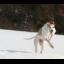

In [22]:
# Probamos una imagen, para verificar la correcta manipulacion de datos
# Nota mental: es un lobito?
import tensorflow as tf
tf.keras.preprocessing.image.array_to_img(y_train0[40])

**Modelo**

Primero definimos una funcion auxiliar

In [0]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Definicion del encoder

In [24]:
# Encoder
# Nota: el input es consistente con el tamanio de Glove50
# Modificar en caso de que probemos un encaje mas grande

original_inputs = Input(shape=(50,), name='encoder_input')
x = Dense(100, activation='relu')(original_inputs)
z_mean = Dense(150, name='z_mean')(x)
z_log_var = Dense(150, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = Model(inputs=original_inputs, outputs=z, name='encoder')

# Final encoder
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          5100        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 150)          15150       dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 150)          15150       dense[0][0]                      
____________________________________________________________________________________________

Definicion del decoder

In [26]:
# Decoder
#batch_size = 2 # pendiente: incorporar esto al modelo

latent_inputs = Input(shape=(150,), name='z_sampling')
x = Dense(300, activation='relu')(latent_inputs)
x = Dense(600, activation='sigmoid')(x)
x = Dense(12288, activation='sigmoid')(x)
outputs = reshape(x, shape=(1, 64, 64, 3))
decoder = Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Final encoder
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 150)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               45300     
_________________________________________________________________
dense_5 (Dense)              (None, 600)               180600    
_________________________________________________________________
dense_6 (Dense)              (None, 12288)             7385088   
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(1, 64, 64, 3)]          0         
Total params: 7,610,988
Trainable params: 7,610,988
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Modelo VAE
outputs = decoder(z)
vae = Model(inputs=original_inputs, outputs=outputs, name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          5100        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 150)          15150       dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 150)          15150       dense[0][0]                      
________________________________________________________________________________________________

In [0]:
# Agregamos la divergencia Kullback Liber para regularizacion de funcion de perdida
kl_loss = - 0.5 * tf.reduce_mean(
    z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

Entrenamos

In [0]:
# Train.
optimizer = RMSprop(learning_rate=1e-4)
vae.compile(optimizer, loss = MeanSquaredError(), metrics=['accuracy'])
vae.fit(x_train0,y_train0, epochs=3, batch_size=1)

Prueba

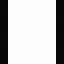

In [76]:
#tf.keras.preprocessing.image.array_to_img(vae.predict(x1).reshape(64,64,3)*255)

**Autoencoder variacional de texto a texto**

In [0]:
# Nota: hice una prueba rapida de lo que mencionaron hoy
# Con glove50 obtenemos buenos resultados, incluso sin maquinaria pesada
x_inputs = Input(shape=(50,))
x = Dense(100, activation='relu')(x_inputs)
z_mean = Dense(150, name='z_mean')(x)
z_log_var = Dense(150, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
x = Dense(100, activation='relu')(z)
x = Dense(50, activation='relu')(x)
modelito = Model(inputs=x_inputs, outputs=x)

In [56]:
optimizer = Adam(learning_rate=1e-3)
modelito.compile(optimizer, loss = MeanSquaredError(), metrics=['accuracy'])
modelito.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 100)          5100        input_9[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 150)          15150       dense_27[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 150)          15150       dense_27[0][0]                   
____________________________________________________________________________________________

In [57]:
modelito.fit(x_train0, x_train0, epochs=10, batch_size=32)

Epoch 1/10
1012/1012 [==============================] - 3s 3ms/step - loss: 885.7127 - accuracy: 0.9129
Epoch 2/10
1012/1012 [==============================] - 2s 2ms/step - loss: 14.7072 - accuracy: 0.9997
Epoch 3/10
1012/1012 [==============================] - 2s 2ms/step - loss: 14.6990 - accuracy: 0.9997
Epoch 4/10
1012/1012 [==============================] - 2s 2ms/step - loss: 14.6642 - accuracy: 0.9997
Epoch 5/10
1012/1012 [==============================] - 2s 2ms/step - loss: 14.6328 - accuracy: 0.9997
Epoch 6/10
1012/1012 [==============================] - 2s 2ms/step - loss: 14.6077 - accuracy: 0.9997
Epoch 7/10
1012/1012 [==============================] - 2s 2ms/step - loss: 14.5589 - accuracy: 0.9997
Epoch 8/10
1012/1012 [==============================] - 2s 2ms/step - loss: 14.5572 - accuracy: 0.9997
Epoch 9/10
1012/1012 [==============================] - 2s 2ms/step - loss: 14.5570 - accuracy: 0.9997
Epoch 10/10
1012/1012 [==============================] - 3s 2ms/step - l

In [41]:
#modelito.predict(x_train0[0,])
x_train0.shape

(32364, 50)

In [59]:
modelito.predict(x_train0)[0]

array([ 0.       ,  1.9761561,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  2.2336767,  0.       ,  0.       ,
        0.       ,  1.9696461,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
       23.027235 ,  0.       ,  0.       ,  0.       ,  0.9319374,
        0.       ,  1.4713194,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  1.2409232,  0.       ,
        0.       ,  0.6230578,  0.       ,  0.       ,  0.       ],
      dtype=float32)

In [0]:
y_inputs = Input(shape=(64,64,3,))
y = Dense(100, activation='relu')(y_inputs)
z_mean = Dense(150, name='z_mean')(y)
z_log_var = Dense(150, name='z_log_var')(y)
z = Sampling()((z_mean, z_log_var))
y = Dense(100, activation='relu')(z)
y = Dense(50, activation='relu')(y)
modelitoy = Model(inputs=y_inputs, outputs=y)

In [63]:
optimizer = Adam(learning_rate=1e-3)
modelitoy.compile(optimizer, loss = MeanSquaredError(), metrics=['accuracy'])
modelito.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 100)          5100        input_9[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 150)          15150       dense_27[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 150)          15150       dense_27[0][0]                   
____________________________________________________________________________________________

In [65]:
modelitoy.fit(y_train0, x_train0, epochs=10, batch_size=32)

Epoch 1/10


ValueError: ignored